## Измерить сечение

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [5]:
# plt.style.use('./pylib/cmd1202.mplstyle')

In [6]:
SEASON = '18'
N_MC = 20000

In [7]:
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False, z_cut=12)
df_mc = preprocess.read_tree(mc_tree, mc=True, z_cut=12)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [6]:
# df_exp.ksalign.hist(bins=100);

In [12]:
# plt.scatter(df_exp['tptot[1]'], df_exp['tdedx[1]'], s=1)

____
## Fit part

In [13]:
energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

501.0 503.0 505.0 508.0 508.5 509.0 509.5 510.0 510.5 511.0 511.5 514.0 517.0 520.0 525.0 530.0 550.0 575.0 600.0 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [14]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

In [45]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [34]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 508.5 MeV


In [46]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse()
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'y0', 'y1', 'm'])
# params_exp['k'] = (0, (0, 0))
params_exp['dy'] = (0., (0, 0))
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse()
assert m_exp.valid

In [36]:
# m_exp.simplex().migrad().hesse()#.minos()

In [37]:
# for par in m_exp.parameters:
#     m_exp.fixed[par] = True if par not in ['n_sig'] else False

In [38]:
print(f' MC: {m_mc.values["n_sig"]:8.2f}, {m_mc.errors["n_sig"]**2:8.2f}')
print(f'Exp: {m_exp.values["n_sig"]:8.2f}, {m_exp.errors["n_sig"]**2:8.2f}')

 MC:  4519.00,  4518.99
Exp: 115499.09, 118727.77


,n_sig_exp,n_bkg_exp,n_sig_mc
501.0,192.626709,16.373313,2926.987450
503.0,1919.813199,17.177018,3682.044046
505.0,2238.796344,9.143964,4158.888997
508.5,115491.996592,0.000021,4519.001635


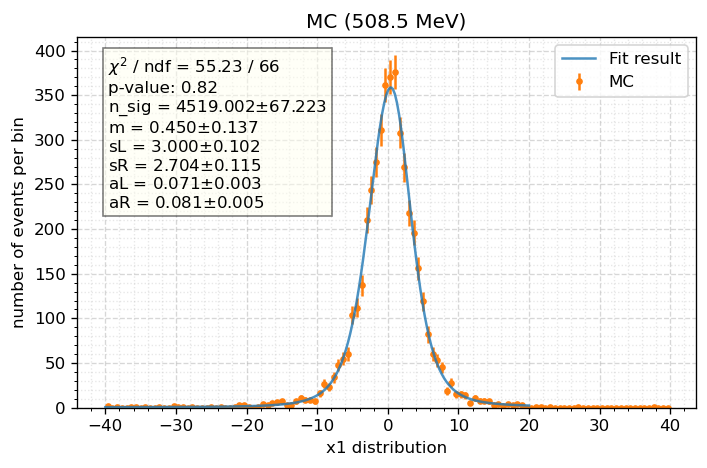

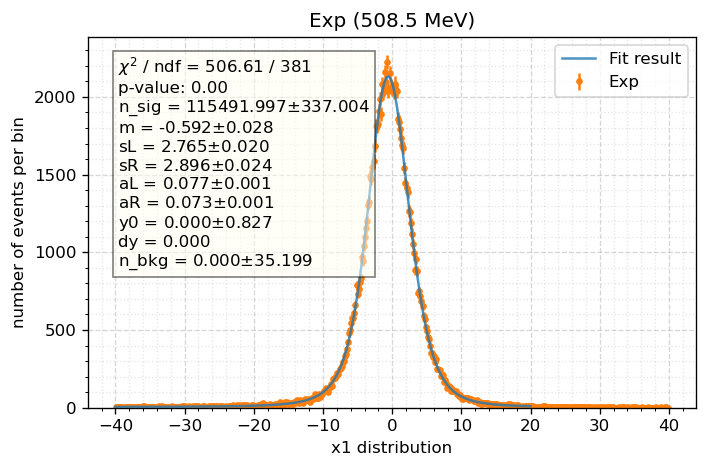

In [47]:
# del res_df
#Plot and save data

def plot_fit_data(save=True):
    pys.plot_fit(dataM, cost_mc, m_mc, 120, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)#, bbox_color=None, fit_color='#CC6FD9', data_color='#9AD9C8')
#     plt.grid(ls=':', alpha=0.2)
    if save:
        if not(os.path.isdir(f'images/fit{SEASON}')):
            os.mkdir(f'images/fit{SEASON}')
        plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, cost_exp, m_exp, 520, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution', alpha=0.8,
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True, fill_errors=False)#, bbox_color=None, fit_color='#CC6FD9', data_color='#8C7B48')
#     plt.grid(alpha=0.2)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)

plot_fit_data(save=True)


def add_postfix(arr, post):
    return [f'{_}_{post}' for _ in arr]
cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
    add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']

if 'res_df' not in locals():
    res_df = pd.DataFrame(columns=cols)

temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=cols, name=e0)
temp_ser['n_bkg_exp'] = width*(2*temp_ser['y0_exp'] + temp_ser['dy_exp'])/2
temp_ser['n_bkg_exp_err'] = width*np.sqrt(2*temp_ser['y0_exp_err']**2 + temp_ser['dy_exp_err']**2)/2

if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

1. [Cowan](http://www.sherrytowers.com/cowan_statistical_data_analysis.pdf)
1. [Unfold1](https://arxiv.org/pdf/1611.01927.pdf)

Распределения

In [ ]:
# res_df.to_csv(f'../data/{SEASON}/results/sys/signal_constant_bkg.csv')

In [41]:
SEASON

'20'

In [62]:
# res_df.to_csv(f'../data/{SEASON}/results/signal.csv')

In [43]:
res_df[['n_sig_exp', 'n_sig_exp_err']].head()

,n_sig_exp,n_sig_exp_err
935.0,96.512047,17.089652
945.0,76.760272,10.347523
950.0,119.845959,13.979371
960.0,123.765576,14.702533
970.0,106.079245,14.821851


Triggers

In [44]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
935.0,89977,934.711914,1,1.404132,1.105659,7.142300,6.016761,465.330902,113.321960,0.328771,...,538.081116,404.763336,0.923170,1.262139,2.342377,474.561127,111.539185,160.084797,-354.098149,0.394550
935.0,89977,934.711914,1,1.342268,1.615378,9.568758,8.346758,251.399765,247.995834,-3.916666,...,574.207153,43.891533,0.985353,22.526104,2.969833,255.730377,247.962784,307.971895,-685.252124,0.171366
935.0,89979,934.711914,1,2.164800,1.109074,-8.636611,-8.627090,201.624100,293.955048,-4.863655,...,553.080261,104.115295,0.981841,7.006157,2.910901,199.159790,287.512085,268.961407,-634.740453,0.190864
935.0,89979,934.711914,3,0.956319,2.026080,-4.990336,-5.755877,200.632996,182.720856,-1.423167,...,471.945679,35.272327,0.979574,100.841072,2.978604,199.371918,182.675751,213.622353,-725.623696,0.202463
935.0,89979,934.711914,3,1.885669,2.074288,-4.191469,-4.506556,269.122375,221.198837,0.311747,...,492.530426,278.176270,0.933210,0.460267,1.951078,268.659546,222.800934,156.697708,-488.588589,0.367552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970.0,96626,970.583313,3,1.935431,1.656314,-0.555425,-0.901419,568.603882,191.686661,0.241960,...,497.307037,654.380249,0.999749,0.821691,1.250007,568.768188,190.630875,54.230108,-170.527021,0.022408
970.0,96626,970.583313,3,1.790303,0.596598,-2.754993,-2.313279,325.648621,186.922699,-0.900730,...,512.415649,293.835144,0.997448,2.492644,2.039225,325.631592,190.805069,178.449515,-509.334609,0.071460
970.0,96627,970.583313,3,1.915156,1.165038,-0.834168,-1.887698,459.055206,156.014404,0.294847,...,498.152008,470.625092,0.999070,1.137610,1.641051,455.127991,155.913300,111.010209,-345.291697,0.043133


In [45]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1, errors='ignore').rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [46]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [47]:
# trig_df.to_csv(f'../data/{SEASON}/results/triggers.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

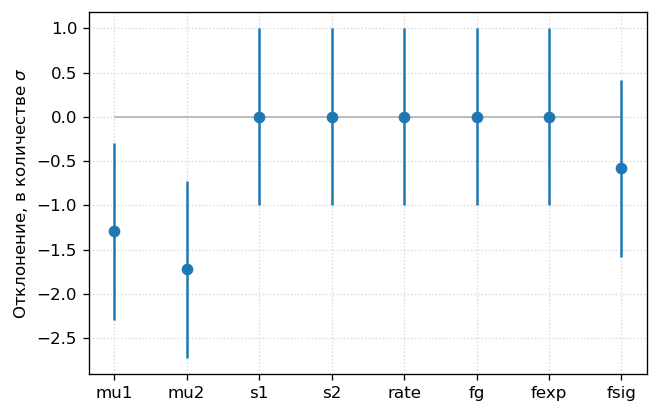

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM

## OMEGA12

In [96]:
df_signal = pd.read_csv('../data/12_omega/results/signal.csv', index_col=0)
df_tr = pd.read_csv('../data/12_omega/results/triggers.csv', index_col=0)
df_lum = pd.read_csv('../data/12_omega/results/lum.csv', index_col=['energy'])

In [117]:
df = pd.concat([df_signal, df_tr, df_lum], axis=1).dropna()
df['emeas'] *= 2

In [118]:
df['corr'] = pd.Series({
    507.: 0.71*0.987,
    508.: 0.7*0.983,
    509.: 0.72*1.028,
    510.: 0.83*0.994,
    512.: 1.08*0.996,
    525.: 1.79,
})

In [122]:
df

,n_sig_exp,n_bkg_exp,m_exp,sL_exp,sR_exp,aL_exp,aR_exp,k_exp,n_sig_exp_err,n_bkg_exp_err,...,effC,effT_err,effC_err,eff_trig,eff_trig_err,lum,lum_err,corr,cs,cs_err
507.0,2139.652883,1.735464e+01,-0.221485,2.655027,2.900028,0.082329,0.076101,19.803762,38.170744,18.192832,...,0.244869,0.007277,0.009285,0.977667,0.005502,70.5469,0.398893,0.70077,213.287492,5.179893
508.0,5562.765273,6.232596e+00,-0.206608,2.721032,2.885417,0.080199,0.071471,17.142645,58.740330,18.976131,...,0.231201,0.005366,0.005675,0.969341,0.004131,60.8262,0.369406,0.68810,644.921120,11.124008
509.0,10821.905227,5.009531e+01,-0.178266,2.633571,2.726754,0.079726,0.076751,0.141352,76.973779,41.506804,...,0.220983,0.004185,0.004000,0.964363,0.003265,52.9112,0.347086,0.74016,1317.707782,19.330169
510.0,8173.782225,4.621083e+01,0.009122,2.771344,3.085351,0.084184,0.076454,19.979887,96.630348,47.192487,...,0.214110,0.004603,0.004544,0.968443,0.003622,58.9441,0.367584,0.82502,808.376911,12.522251
512.0,2480.864823,1.101360e+02,-0.511940,2.434352,5.067231,0.079610,0.096723,19.999999,62.830554,51.473510,...,0.222870,0.007883,0.008206,0.970010,0.006135,57.4664,0.363189,1.07568,181.537500,4.129569
525.0,713.999993,1.109287e-08,0.155742,2.780076,2.144564,0.096825,0.192229,2.801567,18.894347,0.728413,...,0.208745,0.017604,0.015252,0.959423,0.013951,197.4100,0.690676,1.79000,16.902194,0.675496


In [120]:
df['cs'] = df['n_sig_exp']*20000/(df['n_sig_mc']*df['lum']*df['eff_trig']*df['corr'])
df['cs_err'] = df['cs']*np.sqrt( (1/df['n_sig_exp']) +
                               (df['n_sig_mc_err']/df['n_sig_mc'])**2)

In [137]:
df[['emeas', 'cs', 'cs_err', 'lum']]

,emeas,cs,cs_err,lum
507.0,1015.087097,213.287492,5.179893,70.5469
508.0,1017.171997,644.921120,11.124008,60.8262
509.0,1019.088562,1317.707782,19.330169,52.9112
510.0,1021.374329,808.376911,12.522251,58.9441
512.0,1025.427490,181.537500,4.129569,57.4664
525.0,1050.750122,16.902194,0.675496,197.4100


In [134]:
df_koz = pd.read_csv('../data/other/kskl_kozyrev.txt').rename({'E': 'emeas', 'cs': 'cs_born', 'cs_err': 'cs_born_err'}, axis=1)
# df_koz['emeas'] /= 2

In [135]:
df_koz[['emeas', 'cs_born', 'cs_born_err']]

,emeas,cs_born,cs_born_err
0,1004.066,6.87,0.42
1,1010.466,42.16,0.47
2,1012.955,96.74,1.00
3,1015.068,219.53,5.02
4,1016.105,366.33,3.33
5,1017.155,628.15,2.95
6,1017.156,624.76,9.89
7,1018.046,996.62,4.28
8,1019.118,1413.65,6.02
9,1019.214,1433.05,15.03


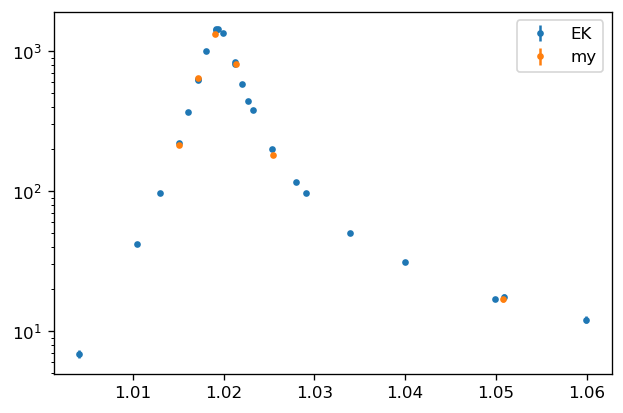

In [136]:
plt.errorbar(df_koz.emeas*1e-3, df_koz.cs_born, yerr=df_koz.cs_born_err, fmt='.', label='EK');
plt.errorbar(df.emeas*1e-3, df.cs, yerr=df.cs_err, fmt='.', label='my')
plt.legend()
plt.yscale('log')

## [Pull distribution](http://physics.rockefeller.edu/luc/technical_reports/cdf5776_pulls.pdf)

In [9]:
dfE, dfM = get_x1(df_exp, df_mc, 525)
dfE, dfM = dfE.query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').copy(), dfM.query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').copy()
dataE, dataM = dfE.x1.values, dfM.x1.values

In [32]:
m_mc.

<FixedView n_sig=False m=False sL=False sR=False aL=False aR=False>

In [36]:
m_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
for i in m_mc.parameters:
    if i not in ['n_sig']:
        m_mc.fixed[i] = True
m_mc.simplex().migrad(iterate=20)
# m_mc = Minuit(costF, 400, 0, 1).simplex().migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -7531                      │              Nfcn = 43               │
│ EDM = 2.16e-11 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │  2.77e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ m     │    0.0    │    0.1    │            │            │   -5    │    5    │  yes  │
│ 2 │ sL    │   2.00    │   0.02    │            │            │    1    │   10    │  yes  │
│ 3 │ sR    │   5.00    │   0.05    │            │            │    1    │   10    │  yes  │
│ 4 │ aL    │    0.0    │    0.1    │            │            │    0    │   10    │  yes  │
│ 5 │ aR    │    0.0    │    0.1    │            │            │    0    │   10    │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │    n_sig        m       sL       sR       aL       aR │
├───────┼───────────────────────────────────────────────────────┤
│ n_sig │ 1.39e+03        0        0        0        0        0 │
│     m │        0        0        0        0        0        0 │
│    sL │        0        0        0        0        0        0 │
│    sR │        0        0        0        0        0        0 │
│    aL │        0        0        0        0        0        0 │
│    aR │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

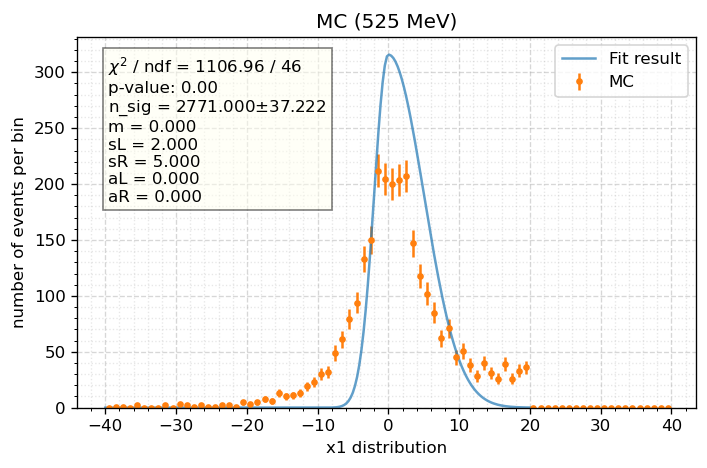

In [37]:
pys.plot_fit(dataM, pyfit.sig_pdf, m_mc, 80, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({525} MeV)', description=True)

In [10]:
from progressbar import progressbar

In [11]:
SAMPLE_SIZE, N_SAMPLES = 400, 400
for i in progressbar(range(N_SAMPLES)):
    dataM_sample = np.random.choice(dataM, SAMPLE_SIZE)
    m_mc_sample = pyfit.fitter(dataM_sample, fit_range, params.copy(), mc=True)
    m_mc_sample.simplex().migrad(iterate=20)
    if i==0:
        vals = {p : np.empty(N_SAMPLES) for p in m_mc_sample.parameters}
        errs = {p : np.empty(N_SAMPLES) for p in m_mc_sample.parameters}
    for par in m_mc_sample.parameters:
        vals[par][i] = m_mc_sample.values[par]
        errs[par][i] = m_mc_sample.errors[par]

100% (400 of 400) |######################| Elapsed Time: 0:01:21 Time:  0:01:21


In [12]:
parameter = 'n_sig'
pull = (vals[parameter]-vals[parameter].mean())/errs[parameter]

In [40]:
pull = np.random.randn(1000)

In [157]:
from scipy.stats import crystalball
import iminuit

def cb(x, beta, m, loc, scale):
    ball = crystalball.pdf(-x, beta, m, loc, scale)
    return ball
# f = lambda x, n0, beta, m, loc, scale: (n0, cb(x, n0, beta, m, loc, scale))

In [158]:
dt, bins = np.histogram(dataM, 100, range=(-40, 20))

In [160]:
cost_function = iminuit.cost.BinnedNLL(dt, bins, cb)
m = Minuit(cost_function,  beta=1, m=1.1, loc=0, scale=3)
# m.fixed['loc']=True

In [161]:
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = nan                        │              Nfcn = 123              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ beta  │     1     │    nan    │            │            │         │         │       │
│ 1 │ m     │    1.1    │    nan    │            │            │         │         │       │
│ 2 │ loc   │     0     │    nan    │            │            │         │         │       │
│ 3 │ scale │     3     │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────┐
│       │  beta     m   loc scale │
├───────┼─────────────────────────┤
│  beta │   nan   nan   nan   nan │
│     m │   nan   nan   nan   nan │
│   loc │   nan   nan   nan   nan │
│ scale │   nan   nan   nan   nan │
└───────┴─────────────────────────┘

TypeError: cb() takes 6 positional arguments but 7 were given

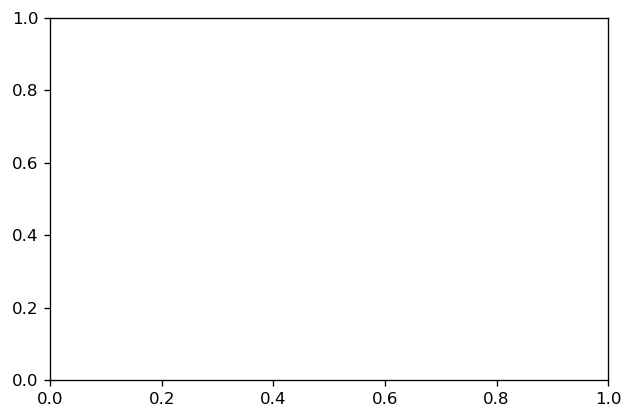

In [139]:
pys.plot_fit(dataM, cb, m, 80, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({525} MeV)', description=True)

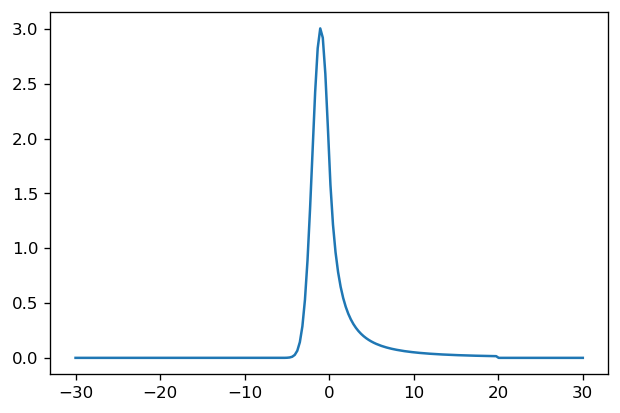

In [112]:
xx = np.linspace(-30, 30, 200)
yy = cb(xx, 10, 1, 2, 1, 1)
plt.plot(xx, yy)

In [45]:
from iminuit import cost, Minuit
gauss = lambda x, n0, mean, sigma: n0*np.exp(-(x - mean)**2/(2*(sigma**2)))/np.sqrt(2*np.pi*(sigma**2))
# costF = cost.ExtendedUnbinnedNLL(pull, lambda x, n0, mean, sigma : (n0, gauss(x, n0, mean, sigma)))
# m_pull = Minuit(costF, 400, 0, 1).simplex().migrad()
m_pull = pyfit.fitter(pull, fit_range, params.copy(), mc=True)
m_pull.simplex().migrad(iterate=20)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8992                      │              Nfcn = 665              │
│ EDM = 2.08e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │   1000    │    22     │            │            │    0    │         │       │
│ 1 │ m     │  -0.011   │   0.021   │            │            │   -5    │    5    │       │
│ 2 │ sL    │   1.000   │   0.014   │            │            │    1    │   10    │       │
│ 3 │ sR    │   1.000   │   0.014   │            │            │    1    │   10    │       │
│ 4 │ aL    │  0.0000   │  0.0017   │            │            │    0    │   10    │       │
│ 5 │ aR    │   0.006   │   0.006   │            │            │    0    │   10    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR │
├───────┼─────────────────────────────────────────────────────────────┤
│ n_sig │       501   0.00172  9.78e-07  0.000247    0.0001   0.00121 │
│     m │   0.00172  0.000464  -2.9e-08 -2.72e-07  2.89e-07 -6.34e-05 │
│    sL │  9.78e-07  -2.9e-08  1.47e-10  6.94e-13 -7.25e-12  2.65e-09 │
│    sR │  0.000247 -2.72e-07  6.94e-13  4.65e-08 -8.26e-09 -3.31e-09 │
│    aL │    0.0001  2.89e-07 -7.25e-12 -8.26e-09  4.98e-09  3.24e-09 │
│    aR │   0.00121 -6.34e-05  2.65e-09 -3.31e-09  3.24e-09  4.22e-05 │
└───────┴─────────────────────────────────────────────────────────────┘

In [46]:
m_pull

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8992                      │              Nfcn = 665              │
│ EDM = 2.08e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │   1000    │    22     │            │            │    0    │         │       │
│ 1 │ m     │  -0.011   │   0.021   │            │            │   -5    │    5    │       │
│ 2 │ sL    │   1.000   │   0.014   │            │            │    1    │   10    │       │
│ 3 │ sR    │   1.000   │   0.014   │            │            │    1    │   10    │       │
│ 4 │ aL    │  0.0000   │  0.0017   │            │            │    0    │   10    │       │
│ 5 │ aR    │   0.006   │   0.006   │            │            │    0    │   10    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR │
├───────┼─────────────────────────────────────────────────────────────┤
│ n_sig │       501   0.00172  9.78e-07  0.000247    0.0001   0.00121 │
│     m │   0.00172  0.000464  -2.9e-08 -2.72e-07  2.89e-07 -6.34e-05 │
│    sL │  9.78e-07  -2.9e-08  1.47e-10  6.94e-13 -7.25e-12  2.65e-09 │
│    sR │  0.000247 -2.72e-07  6.94e-13  4.65e-08 -8.26e-09 -3.31e-09 │
│    aL │    0.0001  2.89e-07 -7.25e-12 -8.26e-09  4.98e-09  3.24e-09 │
│    aR │   0.00121 -6.34e-05  2.65e-09 -3.31e-09  3.24e-09  4.22e-05 │
└───────┴─────────────────────────────────────────────────────────────┘

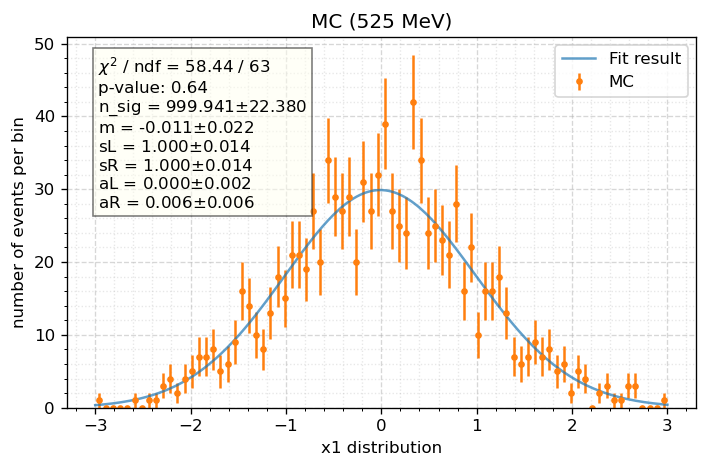

In [53]:
pys.plot_fit(pull, pyfit.sig_pdf, m_pull, 80, (-3, 3), (-3, 3), errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({525} MeV)', description=True)

KeyError: 'sigma'

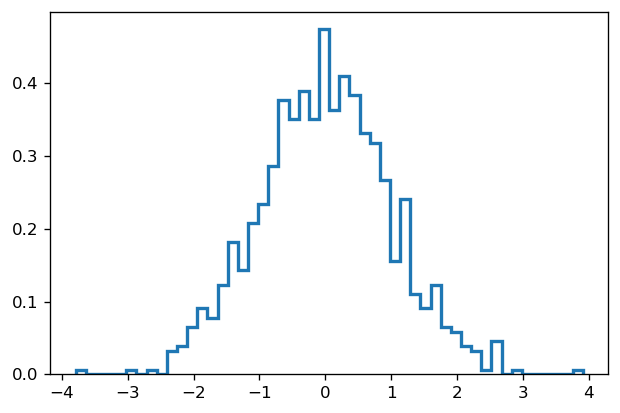

In [47]:
plt.hist(pull, bins=50, histtype='step', lw=2, density=True); #Pull distribution
x_pdf = np.linspace(-3*m_pull.values['sigma'], 3*m_pull.values['sigma'], 100)
plt.plot(x_pdf, gauss(x_pdf, 1, m_pull.values['mean'],  m_pull.values['sigma']))
pys.my_style(f'Pull distribution of "{parameter}"')

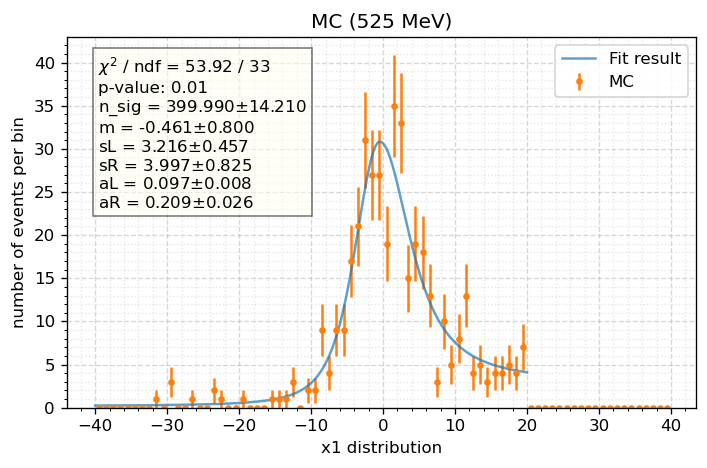

In [17]:
pys.plot_fit(dataM_sample, pyfit.sig_pdf, m_mc_sample, 80, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({525} MeV)', description=True)

#### Binnned NLL

In [47]:
import iminuit
from scipy.stats import norm, crystalball
from progressbar import progressbar

dt = np.random.randn(10000)*2

In [56]:
vals, errs = [], []
for i in progressbar(range(400)):
    dt0 = np.random.choice(dt, np.random.poisson(1000))
    cost0 = iminuit.cost.ExtendedUnbinnedNLL(dt0, lambda x, n, m, s: (n, n*norm.pdf(x, loc=m, scale=s)))
    m = iminuit.Minuit(cost0, n=100, m=0, s=5)
#     m.errordef = iminuit.Minuit.LIKELIHOOD
    m.simplex().migrad()
    vals.append(m.values[0])
    errs.append(m.errors[0])

100% (400 of 400) |######################| Elapsed Time: 0:00:26 Time:  0:00:26


In [58]:
vals, errs = np.array(vals), np.array(errs)

In [59]:
((vals - 1000)/errs).std()

1.0238370905954794

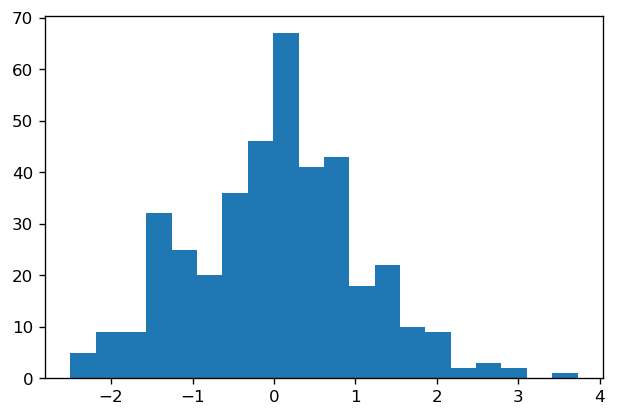

In [51]:
plt.hist((vals - 1000)/errs, bins=20);

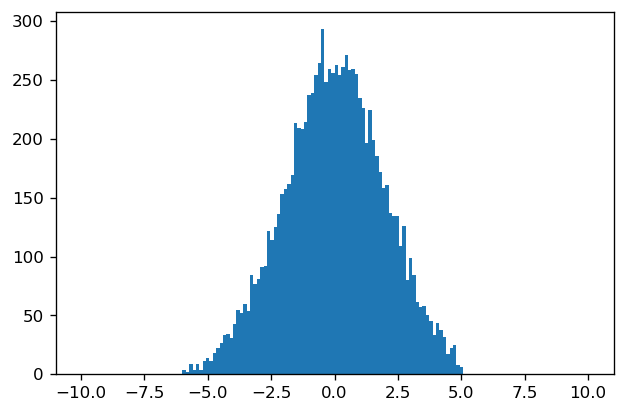

In [33]:
plt.hist(dt, bins=150, range=(-10, 10));

In [34]:
cost = iminuit.cost.ExtendedUnbinnedNLL(dt, lambda x, n, m, s: (n, n*norm.pdf(x, loc=m, scale=s)))

In [35]:
m = iminuit.Minuit(cost, n=100, m=0, s=5)

In [37]:
m.simplex().migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.214e+05                 │              Nfcn = 873              │
│ EDM = 1.37e-08 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │  9.93e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ m    │  -0.015   │   0.020   │            │            │         │         │       │
│ 2 │ s    │   1.961   │   0.014   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         n         m         s │
├───┼───────────────────────────────┤
│ n │  9.93e+03 -4.69e-08  1.15e-08 │
│ m │ -4.69e-08  0.000387   3.3e-07 │
│ s │  1.15e-08   3.3e-07  0.000194 │
└───┴───────────────────────────────┘

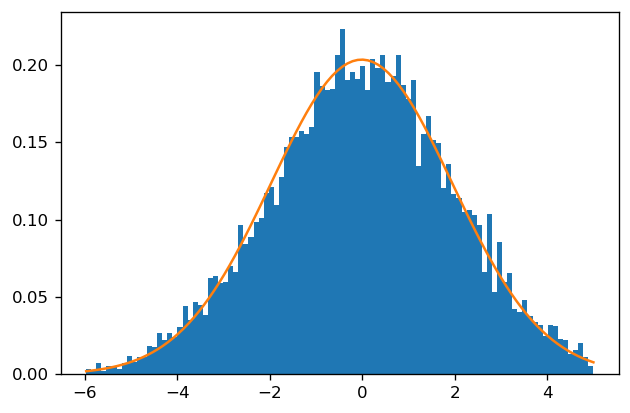

In [40]:
plt.hist(dt, bins=100, density=True);
xx = np.linspace(dt.min(), dt.max(), 100)
yy = cost.scaled_pdf(xx, *m.values)
plt.plot(xx, yy[1]/yy[0])

In [59]:
m.errors['n']**2, m.values['n']

(5163.93898150125, 5163.972874397716)

In [60]:
dat, bins = np.histogram(dt, bins=50)

In [71]:
cost2 = iminuit.cost.ExtendedBinnedNLL(dat, bins, lambda x, n, m, s: n*norm.cdf(x, loc=m, scale=s))

In [72]:
m2 = iminuit.Minuit(cost2, n=100, m=0, s=4)

In [73]:
m2.simplex().migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 98.08                      │              Nfcn = 607              │
│ EDM = 0.000178 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n    │  35.9e6   │   0.5e6   │            │            │         │         │       │
│ 1 │ m    │ -0.004e6  │  0.023e6  │            │            │         │         │       │
│ 2 │ s    │   19e3    │    4e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         n         m         s │
├───┼───────────────────────────────┤
│ n │  2.54e+11 -6.94e+08  9.02e+06 │
│ m │ -6.94e+08  5.13e+08  9.57e+07 │
│ s │  9.02e+06  9.57e+07  1.79e+07 │
└───┴───────────────────────────────┘

<ErrorbarContainer object of 3 artists>

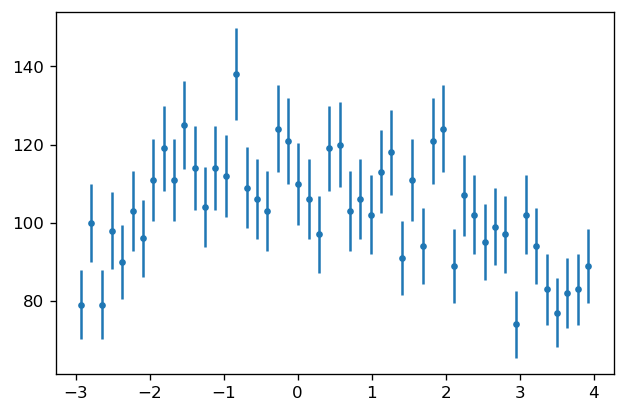

In [77]:
plt.errorbar((bins[1:]+bins[:-1])/2, dat, yerr=np.sqrt(dat), fmt='.')

In [74]:
m2.errors['n']**2, m2.values['n']

(254164528993.14752, 35910187.64043074)